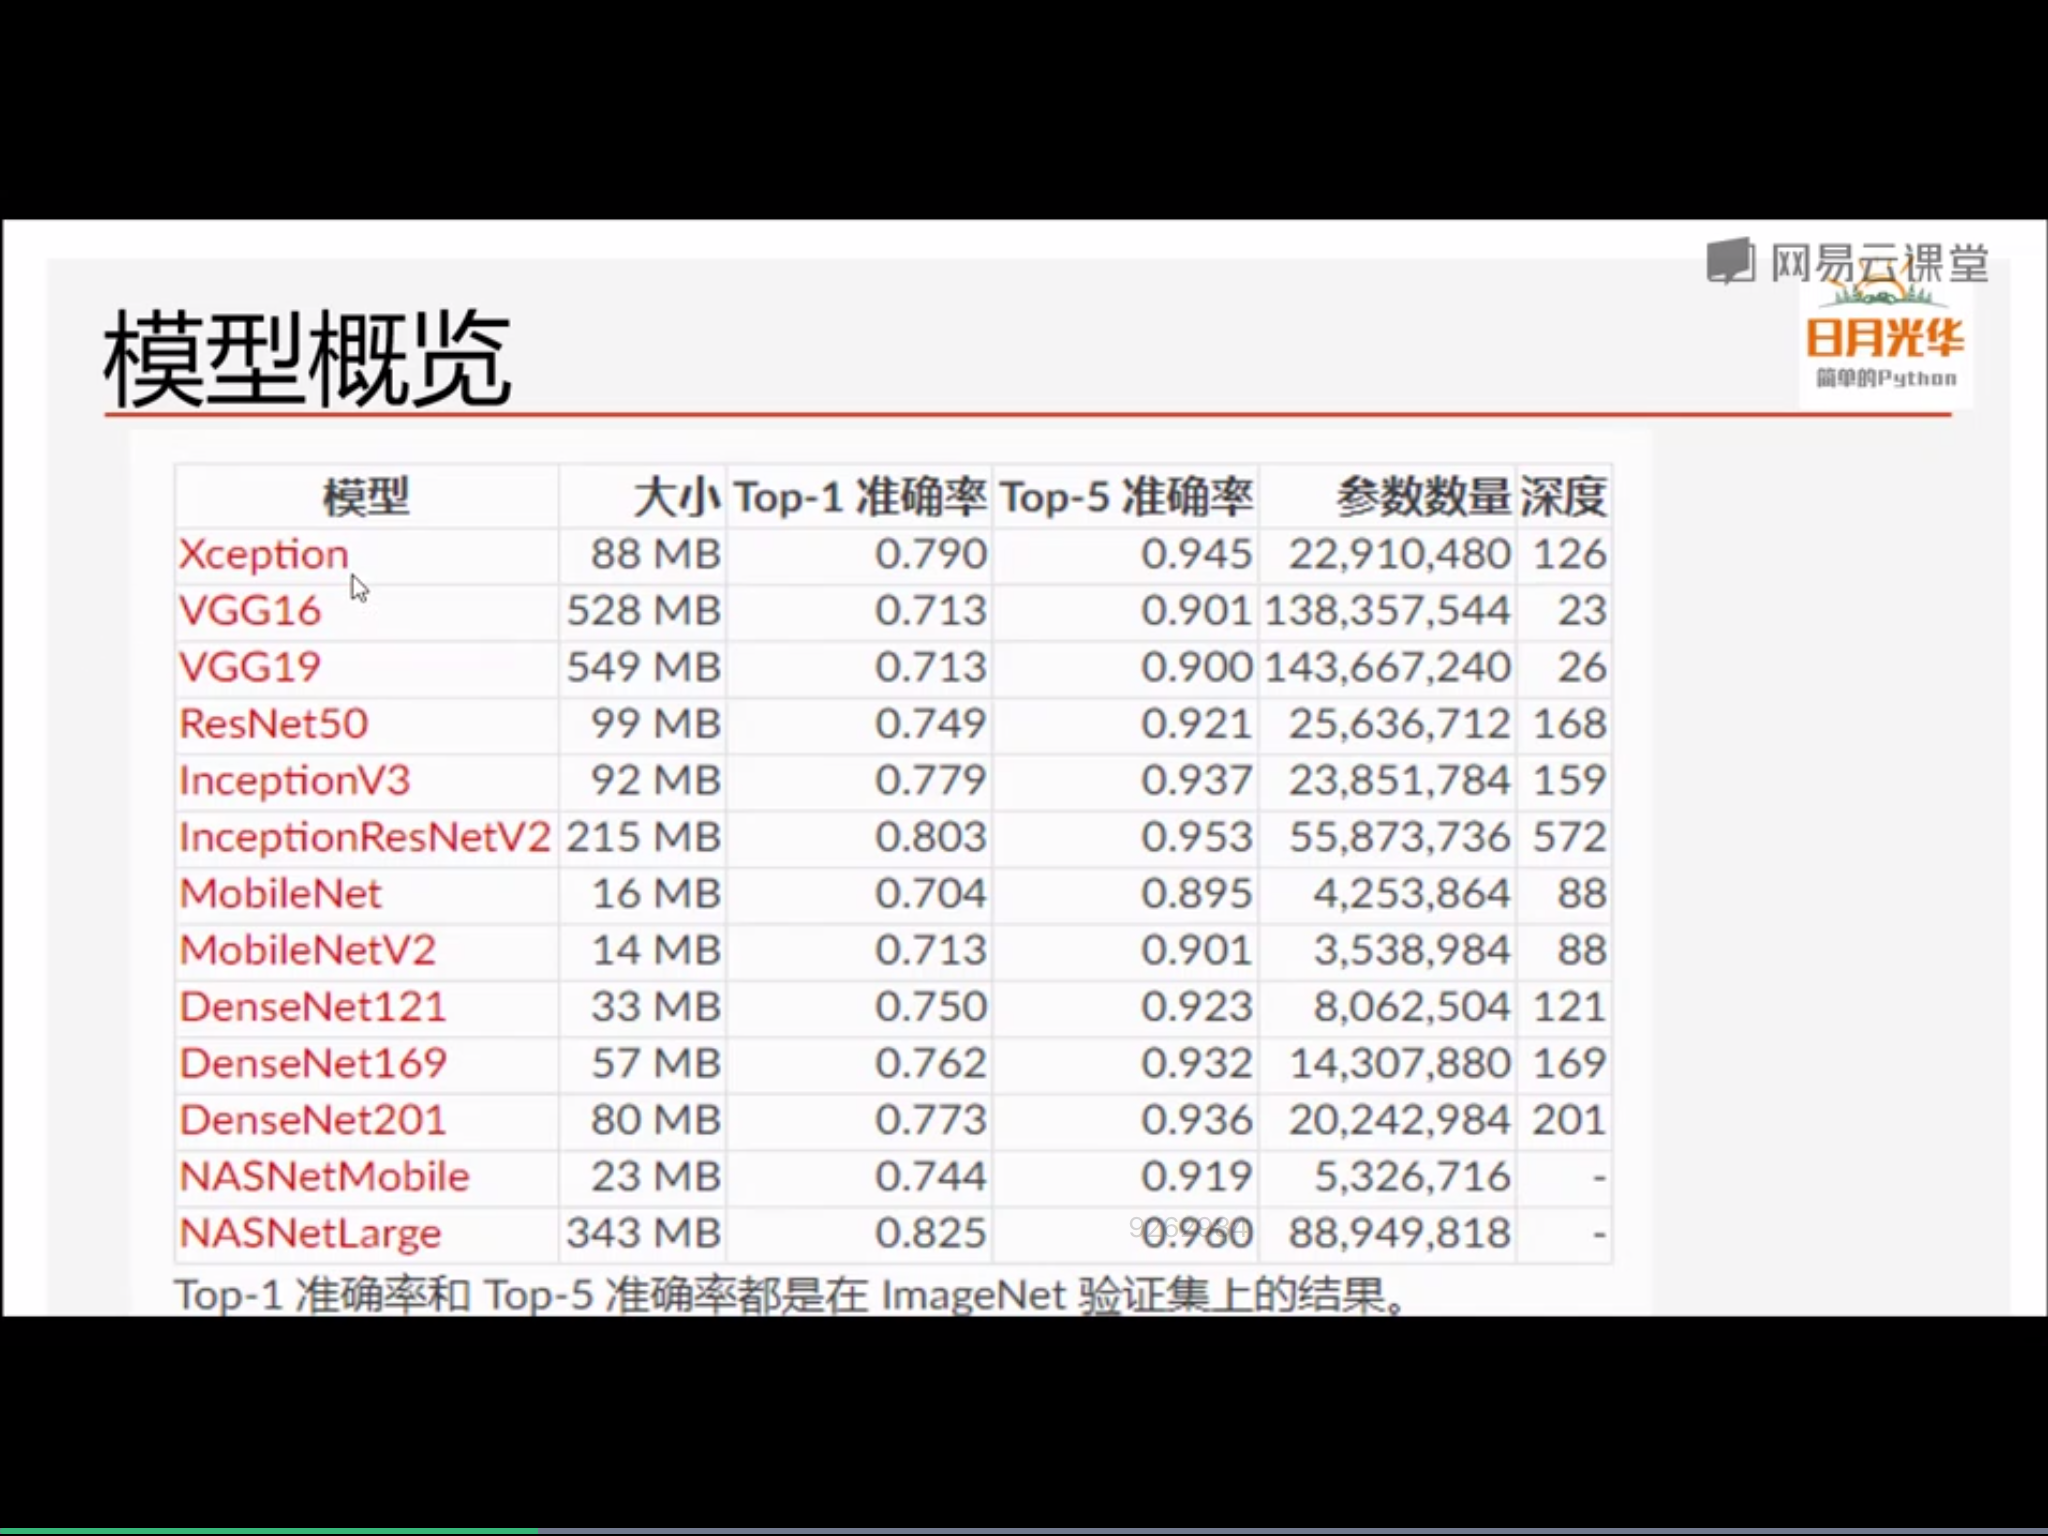

下面对Xception进行说明；

该模型只支持channels_last的维度顺序：(高度、宽度、通道)，模型默认输出尺度为(299,299,3)

相关参数说明：keras.application.xception.Xception()
- include_top：是否包含顶部的全连接层；
- weights：None代表随机初始化，'imagenet'代表加载在ImageNet上预训练权值；
- input_shape：输入尺寸元组，仅当include_top = False时有效（否则输入形状必须是(299,299,3)，因为预训练模型就是按这个大小训练的）。它必须拥有3个通道，且宽和高必须大于71！例如(150, 150, 3)就合理；
- pooling：仅当include_top = False时有效。若为None，表示直接输出最后一层卷积层的输出，为一个4D数组/张量；若为'avg'，表示平均池化(GlobalAveragePooling2D)，相当于在最后一层卷积层后再加一层全局平均池化层，输出一个2D数组/张量（把人为model.add( layers.GlobalAveragePooling2D(input_shape=(6, 6, 512)) )自动生成了）；若为'max'，表示进行全局最大池化。


# 数据处理部分：和前面一样

In [1]:
import keras
from keras import layers
import numpy as np
import os
import shutil    # os和shutil用来处理文件

Using TensorFlow backend.


In [2]:
# 原始数据太多了，现在专门创建一个文件夹来存储一部分要用的训练集 + 测试集
base_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/try'
train_dir = os.path.join(base_dir, 'train')
train_dir_dog = os.path.join(train_dir , 'dog')
train_dir_cat = os.path.join(train_dir , 'cat')

test_dir = os.path.join(base_dir , 'test')
test_dir_dog = os.path.join(test_dir , 'dog')
test_dir_cat = os.path.join(test_dir , 'cat')

dc_dir = 'E:/Python_code/keras_total/日月光华-keras课程资料/dc/train' # 原始数据所在路径

In [3]:
# 训练集猫狗各1000张，测试集猫狗各500张。
if not os.path.exists(base_dir):
    os.mkdir(base_dir)
    os.mkdir(train_dir)
    os.mkdir(train_dir_dog)
    os.mkdir(train_dir_cat)
    os.mkdir(test_dir)
    os.mkdir(test_dir_dog)
    os.mkdir(test_dir_cat)

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname) 
        d = os.path.join(train_dir_cat, fname)
        shutil.copyfile(s, d)   #  把s拷贝到d 

    fnames = ['cat.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_cat, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(train_dir_dog, fname)
        shutil.copyfile(s, d)

    fnames = ['dog.{}.jpg'.format(i) for i in range(1000, 1500)]
    for fname in fnames:
        s = os.path.join(dc_dir, fname)
        d = os.path.join(test_dir_dog, fname)
        shutil.copyfile(s, d)

In [4]:
from keras.preprocessing.image import ImageDataGenerator

# 创建图片的迭代器，并且设定它的归一化
train_datagen = ImageDataGenerator(1/255)
test_datagen = ImageDataGenerator(1/255)

In [5]:
# 正式创建图片的生成器：train
train_generator = train_datagen.flow_from_directory( train_dir,                  # 待读取文件的目录
                                                     target_size = (200,200),    # 图片的统一大小 
                                                     batch_size = 20,            # 每次读入20张
                                                     class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

# 正式创建图片的生成器：test
test_generator = test_datagen.flow_from_directory( test_dir,                  # 待读取文件的目录
                                                    target_size = (200,200),    # 图片的统一大小 
                                                    batch_size = 20,            # 每次读入20张
                                                    class_mode = 'binary'       # 该文件夹下分两类：因为我已经正好在该文件夹下分了两个文件夹
)

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


# 网络搭建：使用Xception预训练网络

In [6]:
conv_base = keras.applications.xception.Xception(
    include_top = False,
    weights = 'imagenet',
    input_shape = (256, 256, 3),  # 自己定义一个
    pooling = 'avg'
)

# 先将卷积基参数冻结：
conv_base.trainable = False 

In [7]:
conv_base.summary()

Model: "xception"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 256, 256, 3)  0                                            
__________________________________________________________________________________________________
block1_conv1 (Conv2D)           (None, 127, 127, 32) 864         input_1[0][0]                    
__________________________________________________________________________________________________
block1_conv1_bn (BatchNormaliza (None, 127, 127, 32) 128         block1_conv1[0][0]               
__________________________________________________________________________________________________
block1_conv1_act (Activation)   (None, 127, 127, 32) 0           block1_conv1_bn[0][0]            
___________________________________________________________________________________________

In [8]:
len(conv_base.layers)  # 加了全局池化后，最后输出是个2D数组：(None, 2048)

133

In [9]:
# 加上全连接层：
from keras import layers

model = keras.Sequential()
model.add(conv_base)  # 把卷积基先加进来
model.add( layers.Dense(512, activation = 'relu') )
model.add( layers.Dense(1, activation = 'sigmoid') )

In [10]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
xception (Model)             (None, 2048)              20861480  
_________________________________________________________________
dense_1 (Dense)              (None, 512)               1049088   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 513       
Total params: 21,911,081
Trainable params: 1,049,601
Non-trainable params: 20,861,480
_________________________________________________________________


In [11]:
len(model.layers)

3

In [12]:
# 模型编译：
model.compile( optimizer = keras.optimizers.Adam(lr=0.0005),
               loss='binary_crossentropy',
               metrics=['acc']
)

Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


In [ ]:
# 训练10轮
history = model.fit( train_features, train_labels, epochs=10, batch_size=50, validation_data=(test_features, test_labels))

使用Xception预训练网络，不需要微调！就已经能达到非常好的结果。说明VGG16这样网络已经过时了。

如果对Xception还想提高精度，那就按同样的操作进行“微调”：

# 微调

In [13]:
conv_base.trainable = open

In [14]:
len(conv_base.layers)

133

In [15]:
final_conv = -33  # 最后33个卷积层都参与训练

In [16]:
for layer in conv_base.layers[:final_conv]:
    layer.trainable = False

In [17]:
# 再次编译：记得将学习调小！
model.compile( optimizer = keras.optimizers.Adam(lr=0.0005/10),
               loss='binary_crossentropy',
               metrics=['acc']
)

In [ ]:
# 再次训练：
initial_epochs = 10   # 前面已经训练了10轮
final_epochs = 5      # 计划再继续训练5轮
total_epochs = initial_epochs + final_epochs  # 记录/打印的训练总轮数：15次

# 速度会快非常多！因为只用训练Dense层的参数！！
history = model.fit( 
    train_features, 
    train_labels, 
    epochs = total_epochs, initial_epoch = initial_epochs,  #  打印/记录会从11开始，到22结束
    batch_size=50, 
    validation_data=(test_features, test_labels)
)